Ante las limitaciones que presentan modelos como ChatGPT, nos planteamos una alternativa:  

**¿Y si, en lugar de generar imágenes completas, utilizamos inpainting en las bounding boxes existentes, evitando así la necesidad de reetiquetar?**

Este enfoque nos pareció mucho más adecuado, por lo que decidimos profundizar en su implementación.  

Para llevarlo a cabo, evaluamos diferentes opciones disponibles para inpainting. Entre ellas, la literatura señalaba a **Stable Diffusion** como la solución más prometedora, destacando por su eficacia y por no presentar una complejidad excesiva en su implementación.

### **¿Qué es el Inpainting?** 🖌  

El inpainting es una técnica avanzada de procesamiento de imágenes que permite rellenar áreas faltantes, dañadas o específicas de una imagen, asegurando que el resultado final mantenga coherencia visual con el resto del contenido. Inspirado en las técnicas tradicionales de restauración de arte, este proceso utiliza el contexto circundante (colores, texturas y patrones) para reconstruir de manera realista las áreas afectadas.  

En el ámbito de la inteligencia artificial, el inpainting se ha perfeccionado con el uso de modelos generativos como **Stable Diffusion**, que emplean redes neuronales para crear contenido visualmente consistente y altamente detallado.  

Por ejemplo, en nuestro caso, utilizamos esta técnica para mejorar datasets de detección de objetos. Partimos de una imagen inicial, definimos una máscara sobre una de las bounding boxes existentes (por ejemplo, un avión), y aplicamos inpainting con Stable Diffusion. El resultado es una imagen que conserva la estructura original, pero incluye un avión generado de forma sintética, listo para ser utilizado en el entrenamiento de modelos sin necesidad de reetiquetado manual.

![gif](https://user-images.githubusercontent.com/11280511/150766125-adf5a3cb-17f2-432c-a8f6-ce0b97122819.gif)

Si consideramos a la mujer como una bounding box, podríamos generar miles de rostros nuevos dentro de esa misma área delimitada, preservando las etiquetas originales de la imagen. Esto permitiría ampliar significativamente el dataset sin necesidad de modificar o reetiquetar manualmente.

#### **Primer experimento**
Flujo para aplicar **inpainting** en áreas específicas de una imagen, utilizando una **bounding box (BB)** como máscara y el modelo **Stable Diffusion**. El proceso está planteado en los siguientes pasos:

1. **Función de generación de máscara (`mask_image_with_bb`)**:
   - A partir de una imagen de entrada y una bounding box, se genera:
     - La imagen original en formato PIL.
     - Una máscara binaria en la que el área delimitada por la bounding box está en blanco (255) y el resto en negro (0).
   - Esto se hace escalando las coordenadas de la bounding box a píxeles y asignando valores a una matriz que luego se convierte en una imagen.

2. **Visualización inicial**:
   - Muestra la imagen original y la máscara generada lado a lado para verificar el área seleccionada.

3. **Aplicación de inpainting con Stable Diffusion**:
   - Utiliza el pipeline de **Stable Diffusion Inpainting** para rellenar el área de la bounding box con un contenido generado a partir de un `prompt`. En este caso, el prompt describe un avión visto desde arriba.
   - El resultado es una nueva imagen donde el contenido dentro de la bounding box ha sido modificado según las indicaciones.

4. **Visualización de resultados**:
   - Muestra tres imágenes: la original, la máscara generada y el resultado del inpainting, para comparar los cambios.


In [ ]:
import os
import shutil
import xml.etree.ElementTree as ET
import xmltodict
from glob import glob

import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from PIL import Image, ImageDraw

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.transforms.functional import to_pil_image
from torchvision.models.detection import ssd300_vgg16, SSD300_VGG16_Weights
from torchvision.models.detection.ssdlite import SSDLiteClassificationHead
from torchvision.models.detection import _utils as det_utils

from diffusers import StableDiffusionInpaintPipeline

from torch.cuda.amp import GradScaler, autocast
from functools import partial
import cv2
import random
import math

In [ ]:
def extract_bboxes_from_voc(xml_path):
    """
    Extrae bounding boxes en formato Pascal VOC de un archivo XML.

    :param xml_path: Ruta al archivo XML con las anotaciones.
    :return: Lista de bounding boxes [(xmin, ymin, xmax, ymax)].
    """
    tree = ET.parse(xml_path)
    root = tree.getroot()

    bboxes = []
    for obj in root.findall("object"):
        bndbox = obj.find("bndbox")
        xmin = int(bndbox.find("xmin").text)
        ymin = int(bndbox.find("ymin").text)
        xmax = int(bndbox.find("xmax").text)
        ymax = int(bndbox.find("ymax").text)
        bboxes.append((xmin, ymin, xmax, ymax))

    return bboxes

In [ ]:
def mask_image_with_bb(image: torch.Tensor, annotations: list) -> (Image.Image, Image.Image):
    """
    Genera una máscara para inpainting con bounding boxes en formato Pascal VOC.

    :param image: Tensor de la imagen original (C, H, W).
    :param annotations: Lista de bounding boxes en formato Pascal VOC (xmin, ymin, xmax, ymax).
    :return: Tuple de (imagen PIL original, máscara PIL).
    """
    _, height, width = image.shape

    # Convertir la imagen de tensor [0, 1] a numpy [0, 255]
    image_np = (image.permute(1, 2, 0).numpy() * 255).astype(np.uint8)

    # Crear la máscara binaria
    mask = np.zeros((height, width), dtype=np.uint8)  # Todo negro

    # Dibujar cada bounding box en la máscara
    for annotation in annotations:
        xmin, ymin, xmax, ymax = annotation
        mask[int(ymin) :int(ymax) , int(xmin) :int(xmax) ] = 255  # Bounding box en blanco

    # Convertir a imágenes PIL
    image_pil = Image.fromarray(image_np)
    mask_pil = Image.fromarray(mask)

    return image_pil, mask_pil


In [ ]:
class CustomDiffusionDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transforms=None):
        self.root_dir = root_dir
        self.transforms = transforms
        self.image_files = sorted([f for f in os.listdir(root_dir) if f.endswith('.jpg')])

        # Verifica si faltan anotaciones XML
        for img_file in self.image_files:
            xml_file = os.path.splitext(img_file)[0] + '.xml'
            if not os.path.exists(os.path.join(root_dir, xml_file)):
                print(f"Advertencia: Falta archivo XML para {img_file}")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Carga la imagen
        img_filename = self.image_files[idx]
        img_path = os.path.join(self.root_dir, img_filename)
        xml_filename = os.path.splitext(img_filename)[0] + '.xml'
        xml_path = os.path.join(self.root_dir, xml_filename)
        img = Image.open(img_path).convert("RGB")  # Asegura que esté en RGB
        original_width, original_height = img.size

        # Procesa las anotaciones
        boxes, labels = self.parse_annotation(xml_path)

        # Aplica transformaciones y escala las cajas
        if self.transforms:
            img = self.transforms(img)
            scale_x = 600 / original_width
            scale_y = 600 / original_height
            boxes = [[xmin * scale_x, ymin * scale_y, xmax * scale_x, ymax * scale_y] for xmin, ymin, xmax, ymax in boxes]

        # Convierte las cajas y etiquetas a tensores
        if len(boxes) == 0:
            boxes_tensor = torch.zeros((0, 4), dtype=torch.float32)
            labels_tensor = torch.zeros((0,), dtype=torch.int64)
        else:
            boxes_tensor = torch.tensor(boxes, dtype=torch.float32)
            labels_tensor = torch.tensor(labels, dtype=torch.int64)

        target = {"boxes": boxes_tensor, "labels": labels_tensor}
        return img, target

    def parse_annotation(self, xml_path):
        """
        Lee y procesa un archivo XML en formato Pascal VOC.
        """
        if not os.path.exists(xml_path):
            print(f"Advertencia: No se encontró el archivo XML: {xml_path}")
            return [], []

        boxes, labels = [], []
        tree = ET.parse(xml_path)
        root = tree.getroot()

        for obj in root.findall("object"):
            label_name = obj.find("name").text
            label = 1 if label_name == 'airplane' else 0  # Ajusta según las clases
            bndbox = obj.find("bndbox")
            xmin = float(bndbox.find("xmin").text)
            ymin = float(bndbox.find("ymin").text)
            xmax = float(bndbox.find("xmax").text)
            ymax = float(bndbox.find("ymax").text)
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(label)

        return boxes, labels


In [ ]:
def visualize_dataset(dataset, num_examples=5):
    """
    Visualiza ejemplos del dataset con imágenes y cajas delimitadoras.

    Args:
        dataset: Instancia del dataset (CustomSSDDataset).
        num_examples: Número de ejemplos a visualizar.
    """
    for idx in range(num_examples):
        # Obtiene la imagen y las anotaciones
        img, target = dataset[idx]

        # Convierte el tensor de imagen a formato PIL si es necesario
        if isinstance(img, torch.Tensor):
            img = to_pil_image(img.clamp(0, 1))

        # Crea la figura para mostrar la imagen
        plt.figure(figsize=(8, 8))
        plt.imshow(img)

        # Extrae las cajas y etiquetas
        boxes = target["boxes"].numpy()
        labels = target["labels"].numpy()

        # Dibuja las cajas delimitadoras
        ax = plt.gca()
        for box, label in zip(boxes, labels):
            xmin, ymin, xmax, ymax = box
            rect = patches.Rectangle(
                (xmin, ymin), xmax - xmin, ymax - ymin,
                linewidth=2, edgecolor='red', facecolor='none'
            )
            ax.add_patch(rect)
            ax.text(xmin, ymin - 5, f"{label}", color="yellow", fontsize=10,
                    bbox=dict(facecolor="red", alpha=0.5))

        # Configuración final de la figura
        plt.axis("off")
        plt.title(f"Ejemplo {idx + 1}")
        plt.show()


In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
test_data =  PATH_XMLS_ORGINAL + 'test/'
train_data = PATH_XMLS_ORGINAL + 'train/'
valid_data = PATH_XMLS_ORGINAL + 'valid/'


train_dataset = CustomDiffusionDataset(train_data, data_transforms)
val_dataset = CustomDiffusionDataset(valid_data, data_transforms)
test_dataset = CustomDiffusionDataset(test_data, data_transforms)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)

In [ ]:
def visualizar_anotaciones(image_dir, num_imagenes):
    """
    Selecciona aleatoriamente un número de imágenes del directorio dado,
    dibuja las anotaciones (bounding boxes) sobre las imágenes y las muestra.

    Args:
    - image_dir (str): Ruta al directorio que contiene imágenes y etiquetas XML.
    - num_imagenes (int): Número de imágenes a seleccionar aleatoriamente.
    """
    # Obtener todas las imágenes del directorio
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]

    # Seleccionar aleatoriamente imágenes
    seleccionadas = random.sample(image_files, min(num_imagenes, len(image_files)))

    for image_file in seleccionadas:
        # Ruta de la imagen
        image_path = os.path.join(image_dir, image_file)
        img = Image.open(image_path)

        # Ruta del archivo XML correspondiente
        annotation_file = os.path.join(image_dir, os.path.splitext(image_file)[0] + '.xml')

        # Verificar si la anotación existe antes de intentar procesarla
        if not os.path.exists(annotation_file):
            print(f"Anotación no encontrada para {image_file}. Saltando...")
            continue

        # Parsear el archivo XML
        tree = ET.parse(annotation_file)
        root = tree.getroot()

        # Dibujar las bounding boxes
        draw = ImageDraw.Draw(img)
        for obj in root.findall('object'):
            label = obj.find('name').text
            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)

            # Dibujar la caja y añadir el label
            draw.rectangle([xmin, ymin, xmax, ymax], outline='red', width=3)
            draw.text((xmin, ymin), label, fill='red')

        # Mostrar la imagen con bounding boxes
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Imagen con anotaciones: {image_file}")
        plt.show()


In [ ]:
# Crear un iterador persistente fuera del código principal
if 'val_iter' not in globals():
    val_iter = iter(val_loader)  # Crear un iterador persistente si no existe

# Seleccionar la primera imagen y su primera etiqueta del iterador persistente
try:
    im, lab = next(val_iter)
except StopIteration:
    # Si el iterador alcanza el final, reiniciarlo
    val_iter = iter(val_loader)
    im, lab = next(val_iter)

image, labels = im[0], lab[0]

# Generar la imagen y la máscara
original_image, mask_image = mask_image_with_bb(image, labels["boxes"].tolist())  # Usar las bounding boxes

# Mostrar la imagen original y la imagen con máscara
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(original_image)
axs[0].set_title("Imagen Original")
axs[0].axis('off')

axs[1].imshow(mask_image, cmap='gray')
axs[1].set_title("Máscara para Inpainting")
axs[1].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# !pip install accelerate -q

In [ ]:
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16,
)

pipe.to("cuda")
prompt = "An aerial view of an airplane. A large airplane is clearly visible on the ground, perfectly centered in the masked area, with its full structure and details rendered realistically."

# Realizar el inpainting
result = pipe(prompt=prompt, image=original_image, num_inference_steps=10, mask_image=mask_image).images[0]

# Mostrar los resultados
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs[0].imshow(original_image)
axs[0].set_title("Imagen Original")
axs[0].axis('off')

axs[1].imshow(mask_image, cmap="gray")
axs[1].set_title("Máscara para Inpainting")
axs[1].axis('off')

axs[2].imshow(result)
axs[2].set_title("Resultado del Inpainting")
axs[2].axis('off')

plt.tight_layout()
plt.show()


Ejemplos de ejecuciones forzando a usar una sola mascara para que se vea más claro cuáles son los resultados óptimos logrados:


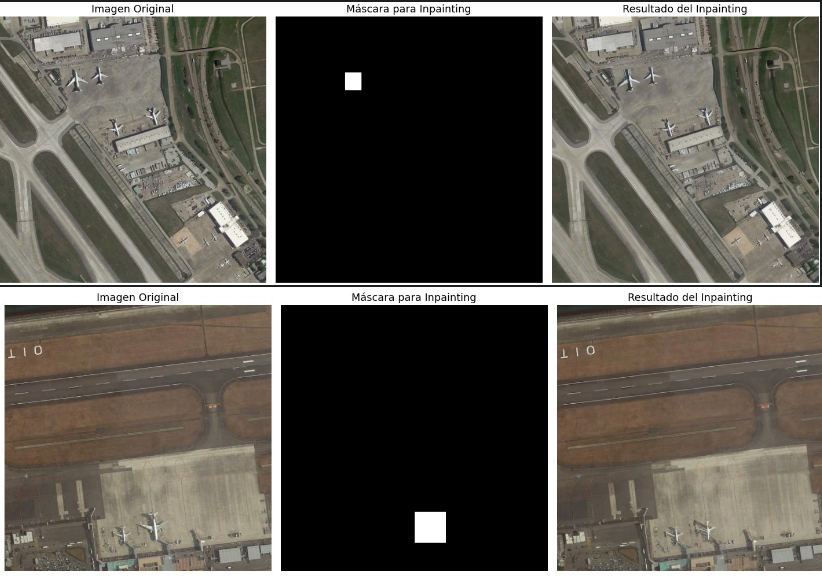

### **Planteamiento y Observaciones Iniciales**

Durante la experimentación con inpainting, observamos que los resultados no cumplían con nuestras expectativas. En algunos casos, el modelo completaba el fondo sin generar el objeto deseado (como un avión), y en otros, el avión generado era de calidad insuficiente. Esto nos llevó a sospechar que el problema podría estar relacionado con el tamaño reducido de las bounding boxes disponibles, ya que estas podrían no proporcionar suficiente contexto al modelo generativo.

### **Propuesta de Solución: Ajuste del Tamaño de las Máscaras**

Para abordar este desafío, diseñamos un flujo experimental en el que modificamos los tamaños de las máscaras mediante la aplicación de un **factor de escala**. Al escalar las bounding boxes, buscamos proporcionar más contexto visual al modelo, con la esperanza de que esto permita generar resultados más coherentes y detallados.

### **Implementación Técnica**

1. **Función `mask_image_with_bb`**:
   - Genera máscaras ajustables basadas en un **factor de escala**. Este factor amplía o reduce las dimensiones de la bounding box antes de generar la máscara binaria (área de interés en blanco, resto en negro).
   - Se asegura de que las coordenadas ajustadas no excedan los límites de la imagen, lo que previene errores.

2. **Modelo de Inpainting**:
   - Se utiliza el pipeline de **Stable Diffusion Inpainting**, que es cargado y preparado para realizar las tareas de generación en GPU.
   - Se proporciona un prompt detallado para guiar la generación del contenido en las áreas delimitadas por las máscaras.

3. **Configuración del Experimento**:
   - **Factores de escala**: Definimos una lista de escalas (`[0.5, 1.0, 1.5, 2.0]`) para experimentar con diferentes tamaños de máscara.
   - **Repeticiones**: Realizamos varias pruebas (`num_trials`) para cada factor de escala, a fin de evaluar la consistencia de los resultados.

4. **Iteración sobre Escalas**:
   - Para cada escala, generamos una máscara y la utilizamos junto con la imagen original para aplicar inpainting mediante el pipeline.
   - Los resultados se almacenan, incluyendo:
     - Imagen original.
     - Máscara generada.
     - Imagen con inpainting aplicado.

5. **Visualización**:
   - Los resultados de cada configuración se visualizan en un conjunto de tres imágenes: la original, la máscara generada y el resultado del inpainting, lo que permite comparar el impacto del ajuste en tiempo real.

In [ ]:

# Función para generar una máscara con bounding boxes en formato Pascal VOC
def mask_image_with_bb(image: torch.Tensor, annotations: list, scale: float = 1.0) -> (Image.Image, Image.Image):
    """
    Genera una máscara para inpainting con bounding boxes en formato Pascal VOC.

    :param image: Tensor de la imagen original (C, H, W).
    :param annotations: Lista de bounding boxes en formato Pascal VOC [(xmin, ymin, xmax, ymax)].
    :param scale: Escala para ajustar el tamaño de las bounding boxes.
    :return: Tuple de (imagen PIL original, máscara PIL).
    """
    _, height, width = image.shape

    # Convertir la imagen de tensor [0, 1] a numpy [0, 255]
    image_np = (image.permute(1, 2, 0).numpy() * 255).astype(np.uint8)

    # Crear la máscara binaria
    mask = np.zeros((height, width), dtype=np.uint8)  # Todo negro

    # Dibujar cada bounding box en la máscara
    for annotation in annotations:
        xmin, ymin, xmax, ymax = annotation
        box_width = (xmax - xmin) * scale
        box_height = (ymax - ymin) * scale

        xmin = max(0, int(xmin - (box_width - (xmax - xmin)) / 2))
        ymin = max(0, int(ymin - (box_height - (ymax - ymin)) / 2))
        xmax = min(width, int(xmax + (box_width - (xmax - xmin)) / 2))
        ymax = min(height, int(ymax + (box_height - (ymax - ymin)) / 2))

        mask[ymin:ymax, xmin:xmax] = 255  # Bounding box en blanco

    # Convertir a imágenes PIL
    image_pil = Image.fromarray(image_np)
    mask_pil = Image.fromarray(mask)

    return image_pil, mask_pil

In [ ]:
# Configuración del pipeline de inpainting
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16,
)
pipe.to("cuda")

# Escalas y configuraciones del experimento
scales = [0.5, 1.0, 1.5, 2.0]  # Factores de escala
num_trials = 3
prompt = "An aerial view of an airplane. A large airplane is clearly visible on the ground, perfectly centered in the masked area, with its full structure and details rendered realistically."

# Crear un iterador persistente para el val_loader
if 'val_iter' not in globals():
    val_iter = iter(val_loader)  # Crear el iterador si no existe

# Realizar el experimento
results = []
try:
    im, lab = next(val_iter)  # Seleccionar el siguiente batch
except StopIteration:
    val_iter = iter(val_loader)
    im, lab = next(val_iter)

image, labels = im[0], lab[0]
annotations = labels["boxes"].tolist()  # Lista de bounding boxes en formato Pascal VOC

for scale in scales:
    for trial in range(num_trials):
        # Generar la imagen y la máscara
        original_image, mask_image = mask_image_with_bb(image, annotations, scale)

        # Realizar el inpainting
        result = pipe(prompt=prompt, image=original_image, num_inference_steps=50, mask_image=mask_image).images[0]

        # Almacenar los resultados
        results.append({
            "scale": scale,
            "trial": trial,
            "original_image": original_image,
            "mask_image": mask_image,
            "inpainting_result": result
        })

# Visualizar los resultados
for result in results:
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    axs[0].imshow(result["original_image"])
    axs[0].set_title(f"Original Image (Scale {result['scale']}, Trial {result['trial']})")
    axs[0].axis('off')

    axs[1].imshow(result["mask_image"], cmap="gray")
    axs[1].set_title("Mask")
    axs[1].axis('off')

    axs[2].imshow(result["inpainting_result"])
    axs[2].set_title("Inpainting Result")
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()

Observamos que el modelo no logra generar contenido significativo, limitándose principalmente a rellenar las áreas definidas. Los mejores resultados se obtienen cuando la bounding box utilizada para crear la máscara se reduce, de manera que cubra solo una parte del avión. En estos casos, el modelo tiende a completar la estructura del avión de forma más coherente. Sin embargo, este enfoque sigue siendo insuficiente, ya que no garantiza la generación de imágenes de calidad ni un comportamiento consistente.

### **Abordando el problema desde un nuevo enfoque**

Dado que en la mayoría de nuestros experimentos iniciales las imágenes generadas o bien rellenaban el fondo de manera poco útil o presentaban una calidad insuficiente, decidimos explorar un nuevo enfoque que pudiera ofrecer mayor control sobre las áreas específicas de generación. Nuestro objetivo era dirigir mejor la generación de contenido en las regiones de interés, en este caso las **bounding boxes**, evitando inconsistencias y logrando una integración más natural con el contexto de la imagen.

### **Implementación: Uso de ControlNet con Stable Diffusion**

Para lograr este nivel de control, adoptamos **ControlNet**, una extensión de Stable Diffusion que permite guiar la generación de imágenes mediante una señal de control (en nuestro caso, contornos detectados en las imágenes originales). Esto permitiría poder reutilizar las bounding boxes ya que deberían de generarse imágenes con estructuras equivalentes.

![gift](https://learnopencv.com/wp-content/uploads/2023/03/controlnet-outputs.gif)

Este enfoque se basa en los siguientes pasos:

1. **Preparación de los datos de control**:
   - Convertimos las imágenes originales en escala de grises para simplificar la extracción de bordes.
   - Utilizamos **Canny Edge Detection** para generar una imagen de contornos que actúa como señal de control. Este paso asegura que los detalles estructurales importantes de las áreas de interés se mantengan en la generación.

2. **Configuración del modelo**:
   - Cargamos el modelo base de **Stable Diffusion** y el modelo de **ControlNet** especializado en detección de contornos.
   - Configuramos un pipeline combinado de Stable Diffusion y ControlNet, que utiliza la señal de contornos para guiar el proceso de generación de imágenes.

3. **Generación de imágenes**:
   - Usamos la imagen de control generada (contornos) junto con un prompt específico, como "An aerial view of an airport with airplanes on the runway", para guiar la generación.
   - Esto nos permitió generar imágenes con aviones que respetan las estructuras y características definidas por los contornos.

4. **Visualización de resultados**:
   - Mostramos lado a lado la **imagen de control (contornos)** y la **imagen generada** para evaluar cómo el modelo respeta los bordes y logra integrar el contenido generado con el contexto deseado.

### **Ventajas de este enfoque**
- **Control estructural**: Al utilizar los contornos como guía, logramos mantener las características esenciales de las áreas de interés, mejorando la coherencia del contenido generado.
- **Flexibilidad**: Este enfoque permite experimentar con diferentes señales de control, como mapas de profundidad, segmentación o contornos, adaptándose a las necesidades específicas del proyecto.
- **Resultados reproducibles**: Al configurar semillas específicas y pasos de inferencia, garantizamos que los resultados puedan ser replicados y evaluados de manera consistente.

In [ ]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel

# Cargar el modelo base de Stable Diffusion
base_model = "runwayml/stable-diffusion-v1-5"

# Cargar el modelo de ControlNet (en este caso, para Canny edge detection)
controlnet_model = "lllyasviel/control_v11p_sd15_canny"
controlnet = ControlNetModel.from_pretrained(controlnet_model, torch_dtype=torch.float16)

# Configurar el pipeline con ControlNet
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    base_model,
    controlnet=controlnet,
    torch_dtype=torch.float16,
)

# Mover a la GPU
pipe.to("cuda")

In [ ]:
# Crear un iterador persistente para el val_loader
if 'val_iter' not in globals():
    val_iter = iter(val_loader)  # Crear el iterador si no existe

# Realizar el experimento
results = []
try:
    im, lab = next(val_iter)  # Seleccionar el siguiente batch
except StopIteration:
    val_iter = iter(val_loader)
    im, lab = next(val_iter)

image, labels = im[0], lab[0]
annotations = labels["boxes"].tolist()  # Lista de bounding boxes en formato Pascal VOC


# Convertir la imagen de PyTorch a numpy y asegurarse de que esté en rango 0-255
image_np = (image.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
print("Forma de la imagen numpy:", image_np.shape)  # Verificar dimensiones

# Convertir a escala de grises si es necesario
if image_np.shape[-1] == 3:  # Imagen RGB
    image_gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
else:
    image_gray = image_np  # Ya está en escala de grises

print("Forma de la imagen en escala de grises:", image_gray.shape)

# Aplicar Canny edge detection
edges = cv2.Canny(image_gray, threshold1=100, threshold2=200)
print("Forma de los contornos (Canny):", edges.shape)

# Convertir los contornos a formato PIL
control_image = Image.fromarray(edges).resize((512, 512))  # Asegurar tamaño correcto
print("Tamaño de la imagen de control:", control_image.size)

Forma de la imagen numpy: (600, 600, 3)
Forma de la imagen en escala de grises: (600, 600)
Forma de los contornos (Canny): (600, 600)
Tamaño de la imagen de control: (512, 512)


In [ ]:
prompt = "An aerial view of an airport with airplanes on the runway."

# Realizar la generación con ControlNet
output = pipe(
    prompt=prompt,
    image=control_image,  # Imagen de control (contornos)
    num_inference_steps=50,  # Número de pasos de inferencia
    generator=torch.manual_seed(42),  # Para resultados reproducibles
    height=512,
    width=512,
)

# Mostrar el resultado
generated_image = output.images[0]
generated_image.show()


In [ ]:
# Mostrar la imagen de control y el resultado
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].imshow(control_image, cmap="gray")
axs[0].set_title("Imagen de Control (Contornos)")
axs[0].axis("off")

axs[1].imshow(generated_image)
axs[1].set_title("Imagen Generada")
axs[1].axis("off")

plt.tight_layout()
plt.show()


Observamos que **ControlNet** enfrenta serias limitaciones al aplicarse a escenarios complejos como el nuestro. Las imágenes de ejemplo proporcionadas por **Stable Diffusion**, aunque efectivas en contextos simples, resultan demasiado básicas en comparación con las exigencias de nuestro problema. Por esta razón, concluimos que este enfoque no es suficiente y decidimos explorar alternativas para abordar nuestras necesidades.

### **Mejor Enfoque**

Tras analizar los resultados de los enfoques anteriores, decidimos volver a la estrategia basada en las **bounding boxes**. Sin embargo, en esta ocasión, abandonamos el uso de inpainting y optamos por emplear un modelo de difusión tradicional, específicamente **"runwayml/stable-diffusion-v1-5"**. Este modelo permite generar imágenes de alta calidad y detalle, y se utiliza junto con una imagen de referencia (un avión visto desde arriba) y un **prompt** bien definido. La combinación de estos elementos nos permite generar aviones que pueden ser superpuestos en las áreas definidas por las bounding boxes.

### **Implementación**

1. **Uso de Stable Diffusion**:
   - Cargamos el modelo preentrenado `runwayml/stable-diffusion-v1-5`.
   - Generamos imágenes hiperrealistas de aviones utilizando un **prompt** detallado y una imagen de referencia, lo que asegura que las características visuales sean consistentes con el contexto de la escena.

2. **Extracción de Bounding Boxes**:
   - A partir de las etiquetas del dataset, calculamos las coordenadas precisas de las bounding boxes (xmin, ymin, xmax, ymax), que definen las áreas de interés en la imagen original.

3. **Generación de Patches**:
   - Para cada bounding box, generamos una imagen que representa un avión visto desde arriba. El uso de la imagen de referencia ayuda a mantener coherencia visual entre los objetos generados.

4. **Superposición de las Imágenes Generadas**:
   - Redimensionamos los patches generados para que coincidan con las dimensiones de las bounding boxes y los superponemos sobre la imagen original en sus respectivas ubicaciones.

5. **Visualización**:
   - Mostramos tres resultados clave:
     1. La imagen original.
     2. Un ejemplo de una imagen generada para un patch.
     3. La imagen final con todos los patches superpuestos en sus posiciones correspondientes.

### **Ventajas del Enfoque**
- **Flexibilidad**: Al utilizar un modelo de difusión estándar, podemos adaptar fácilmente los prompts y las imágenes de referencia para diferentes contextos.
- **Calidad Visual**: Las imágenes generadas son las mejores obtenidas hasta el momento con ese tamaño de máscara (restricción de las bounding boxes) y creemos que pueden llegar a ser suficientes para mejorar el entrenamiento.
- **Automatización**: El proceso permite generar aviones de forma automática sin necesidad de realizar ajustes manuales, lo que mejora la escalabilidad.

In [ ]:
from diffusers import StableDiffusionPipeline

# Cargar el modelo de Stable Diffusion
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
)
pipe.to("cuda")


In [ ]:
def extract_bboxes_from_voc(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    bboxes = []
    for obj in root.findall("object"):
        bndbox = obj.find("bndbox")
        xmin = int(bndbox.find("xmin").text)
        ymin = int(bndbox.find("ymin").text)
        xmax = int(bndbox.find("xmax").text)
        ymax = int(bndbox.find("ymax").text)
        bboxes.append((xmin, ymin, xmax, ymax))

    return bboxes


In [ ]:
# Función para convertir tensores de PyTorch a PIL Images
def tensor_to_pil(image_tensor):
    """
    Convierte un tensor PyTorch [C, H, W] en una imagen PIL.
    """
    image_np = (image_tensor.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    return Image.fromarray(image_np)

In [ ]:
def overlay_generated_patches(original_image, bboxes, generated_patches):
    """
    Superpone las imágenes generadas en las áreas de las bounding boxes.

    :param original_image: PIL Image de la imagen original.
    :param bboxes: Lista de bounding boxes [(xmin, ymin, xmax, ymax)].
    :param generated_patches: Lista de imágenes generadas.
    :return: PIL Image con los patches generados superpuestos.
    """
    result_image = original_image.copy()
    for bbox, patch in zip(bboxes, generated_patches):
        xmin, ymin, xmax, ymax = bbox
        patch_resized = patch.resize((xmax - xmin, ymax - ymin))  # Redimensionar al tamaño de la bounding box
        result_image.paste(patch_resized, (xmin, ymin))
    return result_image

In [ ]:
# Crear un iterador persistente fuera del código principal
if 'val_iter' not in globals():
    val_iter = iter(val_loader)  # Crear un iterador persistente si no existe

# Seleccionar la primera imagen y su primera etiqueta del iterador persistente
try:
    im, lab = next(val_iter)
except StopIteration:
    # Si el iterador alcanza el final, reiniciarlo
    val_iter = iter(val_loader)
    im, lab = next(val_iter)

image, labels = im[0], lab[0]

# Generar la imagen y la máscara
annotations = labels["boxes"].tolist()  # Bounding boxes como lista
original_image = tensor_to_pil(image)

# Asegurar que las bounding boxes están en formato Pascal VOC
bboxes = [(int(box[0]), int(box[1]), int(box[2]), int(box[3])) for box in annotations]

# Cargar la imagen personalizada desde el path
image_path = PATH_PROYECTO + "imagenInpainting.jpg"
custom_image = Image.open(image_path).convert("RGB")  # Convertir a RGB si es necesario
custom_image = custom_image.resize((512, 512))  # Asegurar tamaño compatible con Stable Diffusion

# Generar imágenes hiperrealistas con Stable Diffusion
generated_patches = []
for bbox in bboxes:
    prompt = (
        "An overhead shot of a single white airplane on a plain grey surface, photorealistic and detailed."
    )

    # Generar imagen grande (e.g., 512x512)
    generated_image = pipe(
        prompt=prompt,
        image=custom_image,
        strength=0.85,  # Retiene el 85% del estilo del patch original
        guidance_scale=20,
        num_inference_steps=500
    ).images[0]

    # Almacenar la imagen generada
    generated_patches.append(generated_image)

# Superponer las imágenes generadas en la imagen original
result_image = overlay_generated_patches(original_image, bboxes, generated_patches)

# Mostrar resultados
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Imagen original
axs[0].imshow(original_image)
axs[0].set_title("Imagen Original")
axs[0].axis("off")

# Imagen generada para un patch
axs[1].imshow(generated_patches[0])
axs[1].set_title("Imagen Generada (Patch)")
axs[1].axis("off")

# Imagen final con los patches generados superpuestos
axs[2].imshow(result_image)
axs[2].set_title("Imagen Final con Patches Generados")
axs[2].axis("off")

plt.tight_layout()
plt.show()

### **Evaluación de Resultados y Exploración de Alternativas**

Hemos comenzado a observar resultados con cierto **potencial prometedor** en nuestro flujo de trabajo actual. Aunque aún no alcanzan el nivel óptimo que buscamos, estos resultados nos han permitido identificar oportunidades de mejora y ajustar los parámetros de generación. Sin embargo, para garantizar un enfoque más robusto, hemos decidido explorar otras opciones dentro del espectro de modelos generativos avanzados.

Una de las alternativas que destaca es el modelo **"stabilityai/stable-diffusion-xl-base-1.0"**, conocido por su capacidad para generar contenido de alta calidad gracias a su arquitectura avanzada. Este modelo se caracteriza por su habilidad para capturar detalles complejos y producir imágenes más coherentes visualmente, lo que podría alinearse mejor con nuestras necesidades.

In [ ]:
from diffusers import StableDiffusionXLImg2ImgPipeline

torch.cuda.empty_cache()

# Cargar el modelo SDXL para Img2Img
pipe = StableDiffusionXLImg2ImgPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16,
)
pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionXLImg2ImgPipeline {
  "_class_name": "StableDiffusionXLImg2ImgPipeline",
  "_diffusers_version": "0.32.1",
  "_name_or_path": "stabilityai/stable-diffusion-xl-base-1.0",
  "feature_extractor": [
    null,
    null
  ],
  "force_zeros_for_empty_prompt": true,
  "image_encoder": [
    null,
    null
  ],
  "requires_aesthetics_score": false,
  "scheduler": [
    "diffusers",
    "EulerDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

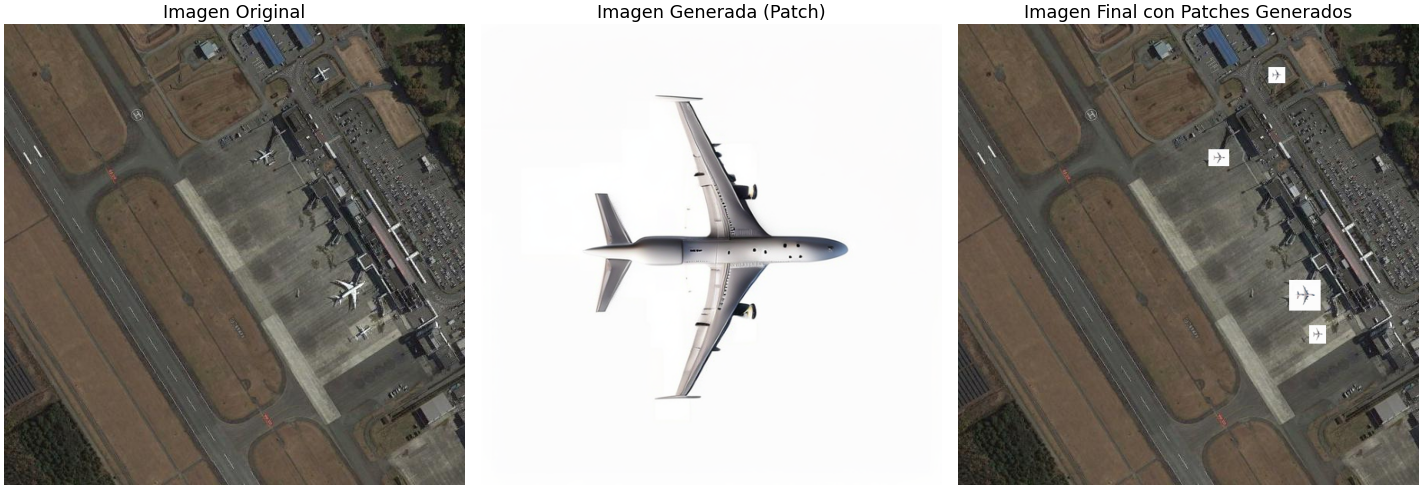

In [ ]:
# Crear un iterador persistente fuera del código principal
if 'val_iter' not in globals():
    val_iter = iter(val_loader)  # Crear un iterador persistente si no existe

# Seleccionar la primera imagen y su primera etiqueta del iterador persistente
try:
    im, lab = next(val_iter)
except StopIteration:
    # Si el iterador alcanza el final, reiniciarlo
    val_iter = iter(val_loader)
    im, lab = next(val_iter)

image, labels = im[0], lab[0]

# Generar la imagen y la máscara
annotations = labels["boxes"].tolist()  # Bounding boxes como lista
original_image = tensor_to_pil(image)

# Asegurar que las bounding boxes están en formato Pascal VOC
bboxes = [(int(box[0]), int(box[1]), int(box[2]), int(box[3])) for box in annotations]

# Cargar la imagen personalizada desde el path
image_path = PATH_PROYECTO + "imagenInpainting.jpg"
custom_image = Image.open(image_path).convert("RGB")  # Convertir a RGB si es necesario
custom_image = custom_image.resize((512, 512))  # Asegurar tamaño compatible con Stable Diffusion

# Generar imágenes hiperrealistas con Stable Diffusion
generated_patches = []
for bbox in bboxes:
    prompt = (
        "An overhead shot of a single white airplane on a plain grey surface, photorealistic and detailed."
    )

    # Generar imagen grande (e.g., 512x512)
    generated_image = pipe(
        prompt=prompt,
        image=custom_image,
        strength=0.65,  # Retiene el 65% del estilo del patch original
        guidance_scale=20,
        num_inference_steps=300
    ).images[0]

    # Almacenar la imagen generada
    generated_patches.append(generated_image)

# Superponer las imágenes generadas en la imagen original
result_image = overlay_generated_patches(original_image, bboxes, generated_patches)

# Mostrar resultados
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Imagen original
axs[0].imshow(original_image)
axs[0].set_title("Imagen Original")
axs[0].axis("off")

# Imagen generada para un patch
axs[1].imshow(generated_patches[0])
axs[1].set_title("Imagen Generada (Patch)")
axs[1].axis("off")

# Imagen final con los patches generados superpuestos
axs[2].imshow(result_image)
axs[2].set_title("Imagen Final con Patches Generados")
axs[2].axis("off")

plt.tight_layout()
plt.show()

### **Análisis de Resultados y Propuesta de Solución**

Al integrar el modelo **Stable Diffusion XL**, observamos que los resultados generados son **notablemente más realistas** en comparación con enfoques previos. Sin embargo, persiste un desafío clave: las imágenes generadas no se integran perfectamente con el fondo original de las imágenes. Esto ocurre porque el modelo, al tomar la **imagen de referencia**, emula fielmente su estilo y contenido, pero no logra adaptarse al contexto global de la escena.

---

### **Problema Identificado**

El principal inconveniente radica en la **falta de cohesión visual** entre los patches generados y el fondo de la imagen original. Esto se debe a que la imagen de referencia utilizada como entrada en el pipeline no refleja el contexto completo de la escena, lo que limita la capacidad del modelo para generar contenido perfectamente alineado.

---

### **Estrategia de Mejora**

Para abordar este problema, planteamos la siguiente estrategia:
1. **Uso de la Bounding Box de Mayor Tamaño como Imagen de Referencia**:
   - En lugar de utilizar una imagen genérica como referencia, recortamos directamente la bounding box de mayor tamaño de la imagen original.
   - Esto permite al modelo trabajar con un contexto visual más representativo de la escena.

2. **Desafíos Adicionales**:
   - El tamaño reducido de las bounding boxes en nuestro dataset sigue siendo un obstáculo. Estas pequeñas dimensiones afectan la **calidad de la imagen de referencia** que se pasa al modelo, lo que puede impactar negativamente en la calidad del contenido generado.
   - A pesar de esta limitación, consideramos que esta estrategia puede ser un paso hacia una mejor integración de los patches generados.

---

### **Implementación Técnica**

1. **Selección de la Bounding Box de Mayor Tamaño**:
   - De todas las bounding boxes presentes en la imagen, identificamos la de mayor área.
   - Recortamos esta sección de la imagen original para usarla como **imagen de referencia**.

2. **Uso en el Pipeline**:
   - La imagen recortada se pasa al modelo **Stable Diffusion XL** junto con un prompt detallado, guiando la generación de contenido dentro del área delimitada.

3. **Evaluación de Resultados**:
   - Comparar los resultados obtenidos utilizando esta estrategia con los generados previamente.
   - Evaluar si la integración visual mejora al utilizar un contexto más específico como referencia.

In [ ]:
# Extraer la bounding box más grande
def get_largest_bbox(bboxes):
    """
    Retorna la bounding box más grande según el área.
    """
    largest_bbox = max(bboxes, key=lambda bbox: (bbox[2] - bbox[0]) * (bbox[3] - bbox[1]))
    return largest_bbox


  0%|          | 0/375 [00:00<?, ?it/s]

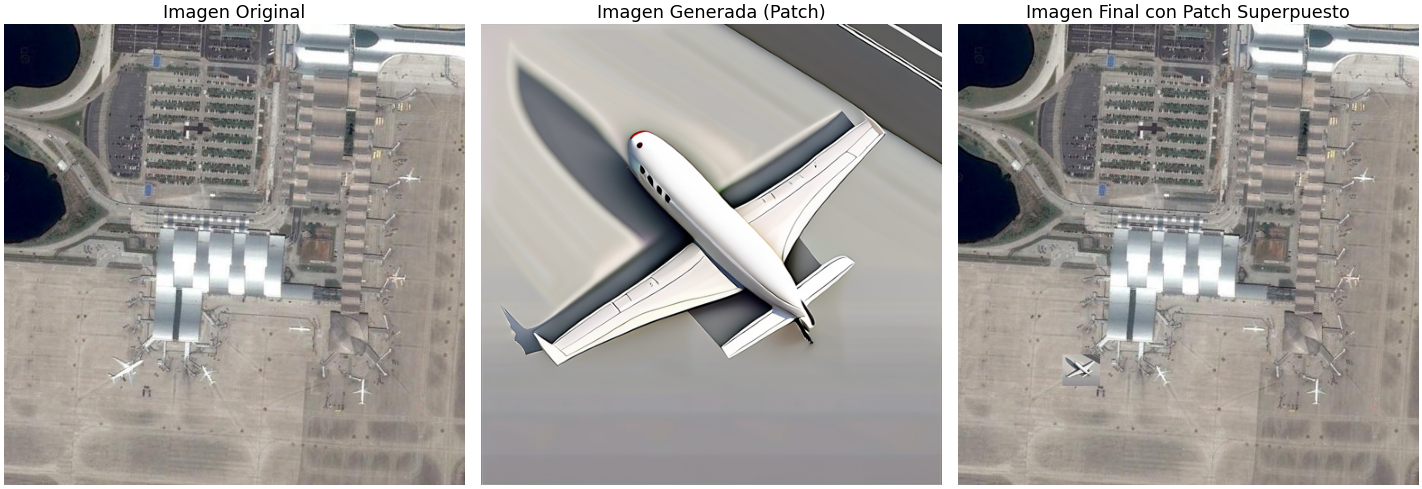

In [ ]:
# Vaciar cache de CUDA
torch.cuda.empty_cache()

# Crear un iterador persistente fuera del código principal
if 'val_iter' not in globals():
    val_iter = iter(val_loader)  # Crear un iterador persistente si no existe

# Seleccionar la primera imagen y su primera etiqueta del iterador persistente
try:
    im, lab = next(val_iter)
except StopIteration:
    # Si el iterador alcanza el final, reiniciarlo
    val_iter = iter(val_loader)
    im, lab = next(val_iter)

image, labels = im[0], lab[0]

# Convertir imagen a PIL
def tensor_to_pil(image_tensor):
    image_np = (image_tensor.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    return Image.fromarray(image_np)

original_image = tensor_to_pil(image)
annotations = labels["boxes"].tolist()

# Obtener la bounding box más grande
largest_bbox = get_largest_bbox(annotations)
xmin, ymin, xmax, ymax = largest_bbox

# Recortar la imagen con la bounding box más grande
cropped_image = original_image.crop((xmin, ymin, xmax, ymax))
cropped_image = cropped_image.resize((512, 512), Image.Resampling.LANCZOS)  # Ajustar tamaño para Stable Diffusion

# Generar imágenes hiperrealistas con Stable Diffusion
prompt = (
    "An overhead shot of a single white airplane on a plain grey road, photorealistic and detailed."
)
generated_image = pipe(
    prompt=prompt,
    image=cropped_image,
    strength=0.75,  # Incrementar para más creatividad
    guidance_scale=25,  # Aumentar la creatividad
    num_inference_steps=500,  # Más pasos para mayor calidad
).images[0]

# Superponer el patch generado en la imagen original
def overlay_patch_on_image(original_image, bbox, patch):
    """
    Superpone un patch generado en la imagen original usando las coordenadas de la bounding box.
    """
    result_image = original_image.copy()

    # Convertir las dimensiones a enteros
    patch_width = int(bbox[2] - bbox[0])
    patch_height = int(bbox[3] - bbox[1])

    patch_resized = patch.resize((patch_width, patch_height), Image.Resampling.LANCZOS)
    result_image.paste(patch_resized, (int(bbox[0]), int(bbox[1])))
    return result_image


result_image = overlay_patch_on_image(original_image, largest_bbox, generated_image)

# Mostrar resultados
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Imagen original
axs[0].imshow(original_image)
axs[0].set_title("Imagen Original")
axs[0].axis("off")

# Imagen generada (a partir del crop)
axs[1].imshow(generated_image)
axs[1].set_title("Imagen Generada (Patch)")
axs[1].axis("off")

# Imagen final con el patch superpuesto
axs[2].imshow(result_image)
axs[2].set_title("Imagen Final con Patch Superpuesto")
axs[2].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# mostrar la cropped image:
plt.imshow(cropped_image)
plt.axis("off")
plt.show()

### **Expansión del Enfoque: Aplicación a Todas las Bounding Boxes**

Tras observar resultados significativamente más prometedores al utilizar la bounding box de mayor tamaño como referencia, decidimos **ampliar el enfoque** para aplicar el modelo generativo a **todas las bounding boxes de cada imagen**. Esta estrategia tiene como objetivo maximizar el impacto del data augmentation en el dataset completo.

---

### **Adaptación del Proceso**

En lugar de limitar el pipeline al área delimitada por la bounding box más grande, ahora:
1. **Iteramos sobre todas las bounding boxes** presentes en una imagen.
2. **Redimensionamos los patches generados** para que se ajusten a las dimensiones específicas de cada bounding box.
3. **Superponemos los patches generados** en sus ubicaciones correspondientes, respetando la estructura original de la imagen.


  0%|          | 0/37 [00:00<?, ?it/s]

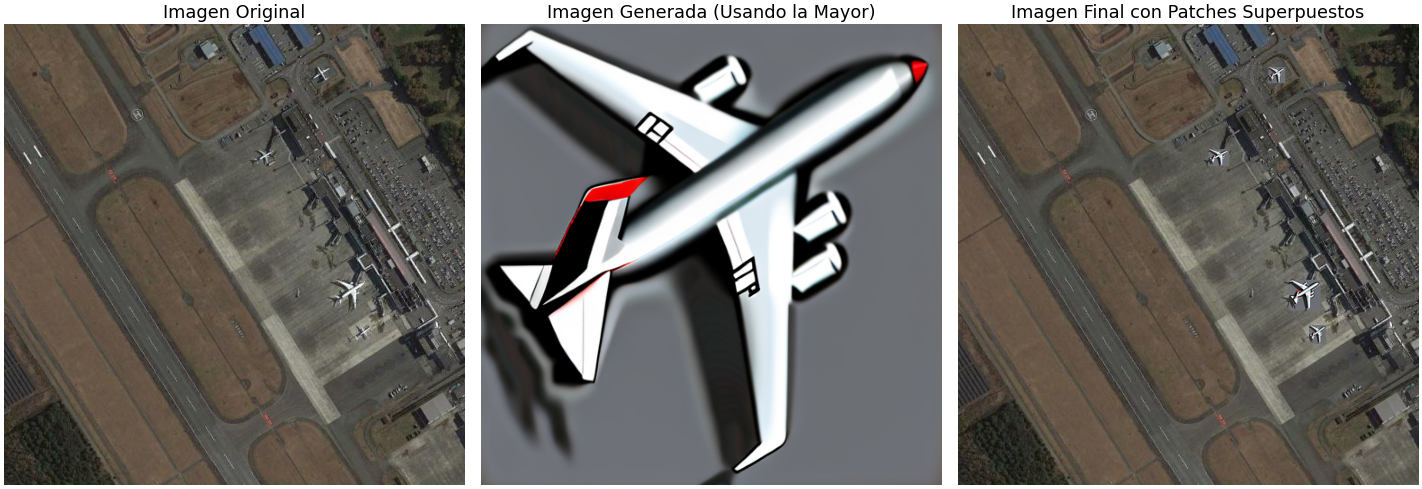

In [ ]:
import torch
from PIL import Image
import matplotlib.pyplot as plt


# Vaciar cache de CUDA
torch.cuda.empty_cache()

# Crear un iterador persistente fuera del código principal
if 'val_iter' not in globals():
    val_iter = iter(val_loader)  # Crear un iterador persistente si no existe

# Seleccionar la primera imagen y su primera etiqueta del iterador persistente
try:
    im, lab = next(val_iter)
except StopIteration:
    # Si el iterador alcanza el final, reiniciarlo
    val_iter = iter(val_loader)
    im, lab = next(val_iter)

image, labels = im[0], lab[0]

# Convertir imagen de tensor a PIL
def tensor_to_pil(image_tensor):
    """
    Convierte un tensor PyTorch [C, H, W] en una imagen PIL.
    """
    image_np = (image_tensor.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    return Image.fromarray(image_np)

original_image = tensor_to_pil(image)
annotations = labels["boxes"].tolist()

# Obtener la bounding box más grande
largest_bbox = get_largest_bbox(annotations)
xmin, ymin, xmax, ymax = largest_bbox

# Recortar la imagen con la bounding box más grande
cropped_image = original_image.crop((xmin, ymin, xmax, ymax))
cropped_image = cropped_image.resize((512, 512), Image.Resampling.LANCZOS)  # Ajustar tamaño para Stable Diffusion

# Generar una imagen hiperrealista con Stable Diffusion
prompt = "An overhead shot of a single white airplane on a plain grey surface, photorealistic and detailed."
generated_image = pipe(
    prompt=prompt,
    image=cropped_image,
    strength=0.75,  # Incrementar para más creatividad
    guidance_scale=25,  # Aumentar la creatividad
    num_inference_steps=50,  # Más pasos para mayor calidad
).images[0]

# Superponer el mismo patch generado en todas las bounding boxes
def overlay_generated_patches(original_image, bboxes, patch):
    """
    Superpone el mismo patch generado en todas las bounding boxes de la imagen original.
    """
    result_image = original_image.copy()
    for bbox in bboxes:
        xmin, ymin, xmax, ymax = bbox
        patch_resized = patch.resize((int(xmax - xmin), int(ymax - ymin)), Image.Resampling.LANCZOS)
        result_image.paste(patch_resized, (int(xmin), int(ymin)))
    return result_image

result_image = overlay_generated_patches(original_image, annotations, generated_image)

# Mostrar resultados
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Imagen original
axs[0].imshow(original_image)
axs[0].set_title("Imagen Original")
axs[0].axis("off")

# Imagen generada (a partir del crop más grande)
axs[1].imshow(generated_image)
axs[1].set_title("Imagen Generada (Usando la Mayor)")
axs[1].axis("off")

# Imagen final con los patches superpuestos
axs[2].imshow(result_image)
axs[2].set_title("Imagen Final con Patches Superpuestos")
axs[2].axis("off")

plt.tight_layout()
plt.show()


### **Evaluación y Decisión: Automatización del Proceso para un Dataset Completo**

Después de analizar diferentes enfoques, descartamos la estrategia de iterar sobre cada bounding box individualmente generando imagenes para cada bounding box debido a los siguientes motivos:

1. **Ineficiencia Temporal**: Generar imágenes de manera individual para cada bounding box incrementaría drásticamente el tiempo de procesamiento. Para hacerlo viable, sería necesario reducir el valor de `num_inference_steps`, lo que comprometería la calidad de las imágenes generadas.

2. **Calidad Inferior en Bounding Boxes Pequeñas**: La generación de contenido en bounding boxes muy pequeñas es especialmente desafiante, ya que el tamaño reducido limita el contexto visual que el modelo generativo puede aprovechar. Esto resulta en imágenes de baja calidad que no cumplen con los estándares necesarios para un dataset efectivo.

---

### **Base para Futuras Iteraciones**

Los resultados obtenidos al utilizar la bounding box más grande como referencia han demostrado ser prometedores. Por ello, establecemos esta estrategia como **el punto de partida** para automatizar el proceso de data augmentation en el dataset completo. Este enfoque permite mejorar el dataset sin comprometer la calidad o la eficiencia del proceso.

---

### **Automatización del Proceso**

A continuación, procederemos a desarrollar un pipeline que:
1. Itere automáticamente sobre todas las imágenes y sus respectivas bounding boxes en el dataset.
2. Genere imágenes sintéticas de alta calidad utilizando modelos generativos.
3. Conserve las etiquetas originales (bounding boxes y clases) para garantizar la coherencia del dataset aumentado.

Esta automatización permitirá duplicar o incrementar significativamente el tamaño del dataset, maximizando su valor para entrenar modelos de detección robustos y eficientes. Este paso marca un avance clave hacia un enfoque escalable y efectivo para mejorar el rendimiento en tareas de visión por computador.

### **Pasamos ahora a automatizar el proceso para un dataset completo**

Necesitamos modificar cómo se toman los datos del dataset para que `__getitem__` devuelva img, target, img_filename, y xml_filename

In [ ]:
class CustomDiffusionDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transforms=None):
        self.root_dir = root_dir
        self.transforms = transforms
        self.image_files = sorted([f for f in os.listdir(root_dir) if f.endswith('.jpg')])

        # Verifica si faltan anotaciones XML
        for img_file in self.image_files:
            xml_file = os.path.splitext(img_file)[0] + '.xml'
            if not os.path.exists(os.path.join(root_dir, xml_file)):
                print(f"Advertencia: Falta archivo XML para {img_file}")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Carga la imagen
        img_filename = self.image_files[idx]
        img_path = os.path.join(self.root_dir, img_filename)
        xml_filename = os.path.splitext(img_filename)[0] + '.xml'
        xml_path = os.path.join(self.root_dir, xml_filename)
        img = Image.open(img_path).convert("RGB")  # Asegura que esté en RGB
        original_width, original_height = img.size

        # Procesa las anotaciones
        boxes, labels = self.parse_annotation(xml_path)

        # Aplica transformaciones y escala las cajas
        if self.transforms:
            img = self.transforms(img)
            scale_x = 600 / original_width
            scale_y = 600 / original_height
            boxes = [[xmin * scale_x, ymin * scale_y, xmax * scale_x, ymax * scale_y] for xmin, ymin, xmax, ymax in boxes]

        # Convierte las cajas y etiquetas a tensores
        if len(boxes) == 0:
            boxes_tensor = torch.zeros((0, 4), dtype=torch.float32)
            labels_tensor = torch.zeros((0,), dtype=torch.int64)
        else:
            boxes_tensor = torch.tensor(boxes, dtype=torch.float32)
            labels_tensor = torch.tensor(labels, dtype=torch.int64)

        target = {"boxes": boxes_tensor, "labels": labels_tensor}
        return img, target, img_filename, xml_filename

    def parse_annotation(self, xml_path):
        """
        Lee y procesa un archivo XML en formato Pascal VOC.
        """
        if not os.path.exists(xml_path):
            print(f"Advertencia: No se encontró el archivo XML: {xml_path}")
            return [], []

        boxes, labels = [], []
        tree = ET.parse(xml_path)
        root = tree.getroot()

        for obj in root.findall("object"):
            label_name = obj.find("name").text
            label = 1 if label_name == 'airplane' else 0  # Ajusta según las clases
            bndbox = obj.find("bndbox")
            xmin = float(bndbox.find("xmin").text)
            ymin = float(bndbox.find("ymin").text)
            xmax = float(bndbox.find("xmax").text)
            ymax = float(bndbox.find("ymax").text)
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(label)

        return boxes, labels


In [ ]:
# Visualizar ejemplos del dataset
def visualize_dataset(dataset, num_examples=5):
    """
    Visualiza ejemplos del dataset con imágenes y sus bounding boxes.

    Args:
        dataset: Instancia del dataset (CustomSSDDataset).
        num_examples: Número de ejemplos a visualizar.
    """
    for idx in range(num_examples):
        # Obtener imagen, anotaciones y nombres de archivo
        img, target, img_filename, xml_filename = dataset[idx]

        # Convertir imagen a formato PIL si es un tensor
        if isinstance(img, torch.Tensor):
            img = transforms.ToPILImage()(img)

        # Crear figura para mostrar la imagen
        plt.figure(figsize=(8, 8))
        plt.imshow(img)

        # Extraer las cajas y etiquetas
        boxes = target["boxes"].numpy()
        labels = target["labels"].numpy()

        # Dibujar las cajas delimitadoras
        ax = plt.gca()
        for box, label in zip(boxes, labels):
            xmin, ymin, xmax, ymax = box
            rect = patches.Rectangle(
                (xmin, ymin), xmax - xmin, ymax - ymin,
                linewidth=2, edgecolor='red', facecolor='none'
            )
            ax.add_patch(rect)
            ax.text(
                xmin, ymin - 5, f"Label: {label}",
                color="yellow", fontsize=10,
                bbox=dict(facecolor="red", alpha=0.5)
            )

        # Configuración de la figura
        plt.axis("off")
        plt.title(f"Imagen: {img_filename}, Anotación: {xml_filename}")
        plt.show()

Comprobamos que esta nueva forma de tomar los datasets funcione correctamente

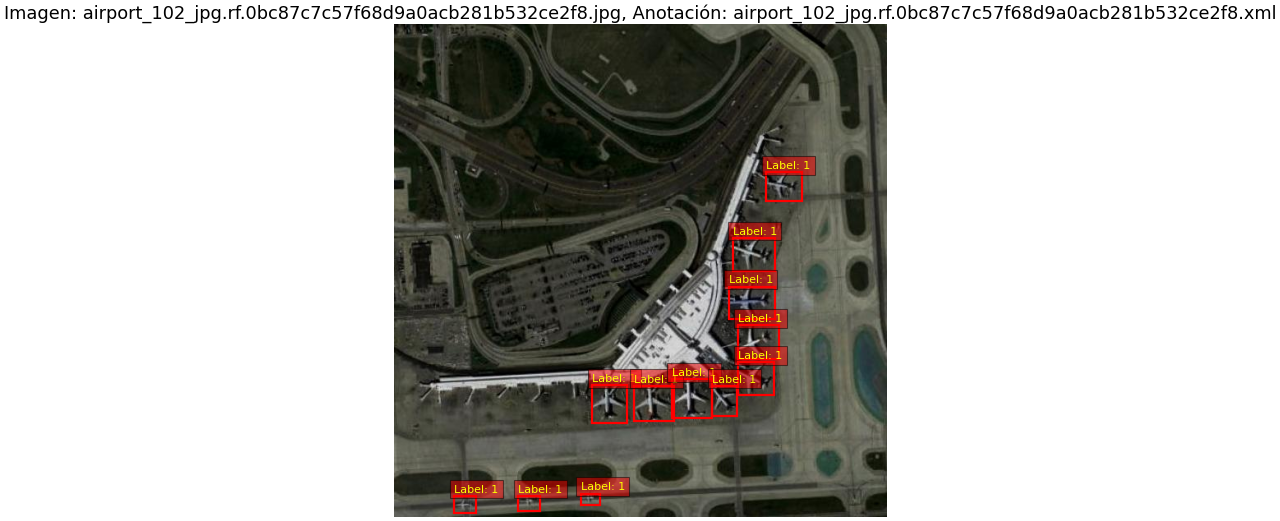

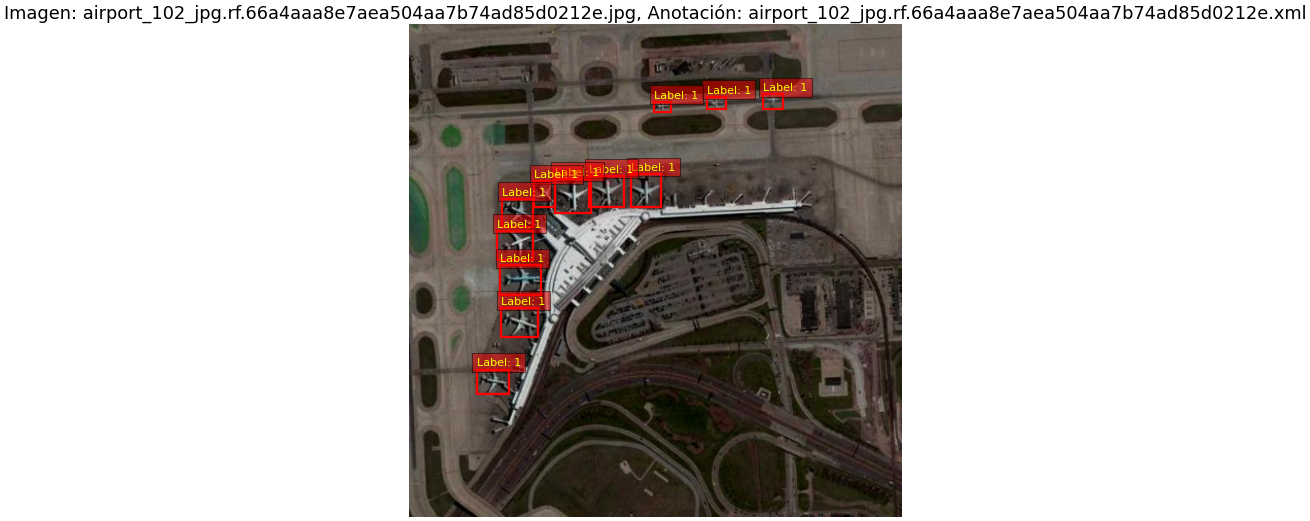

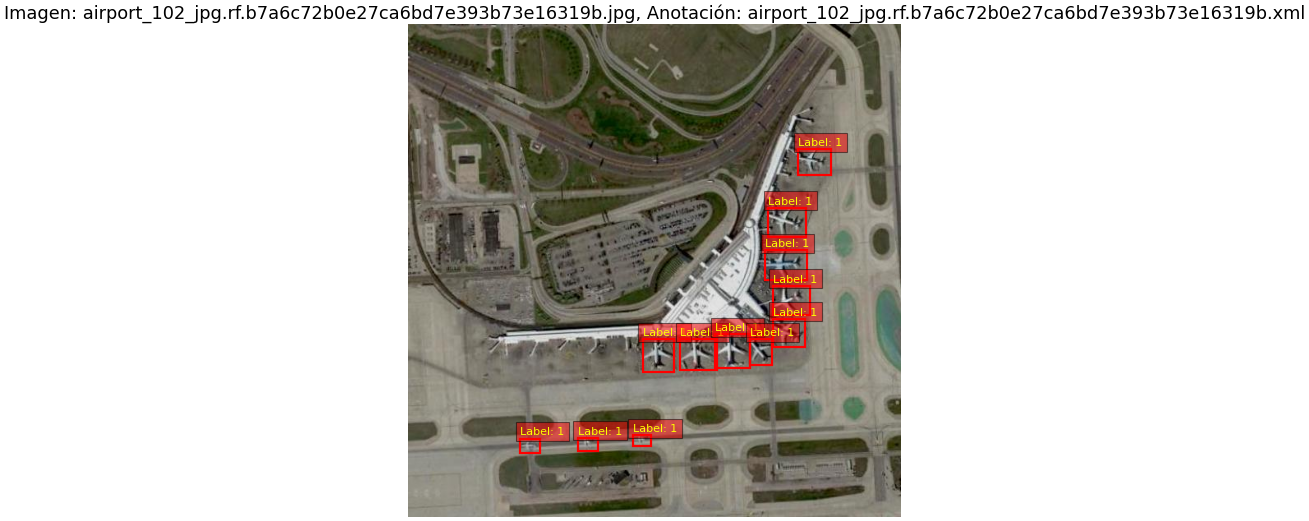

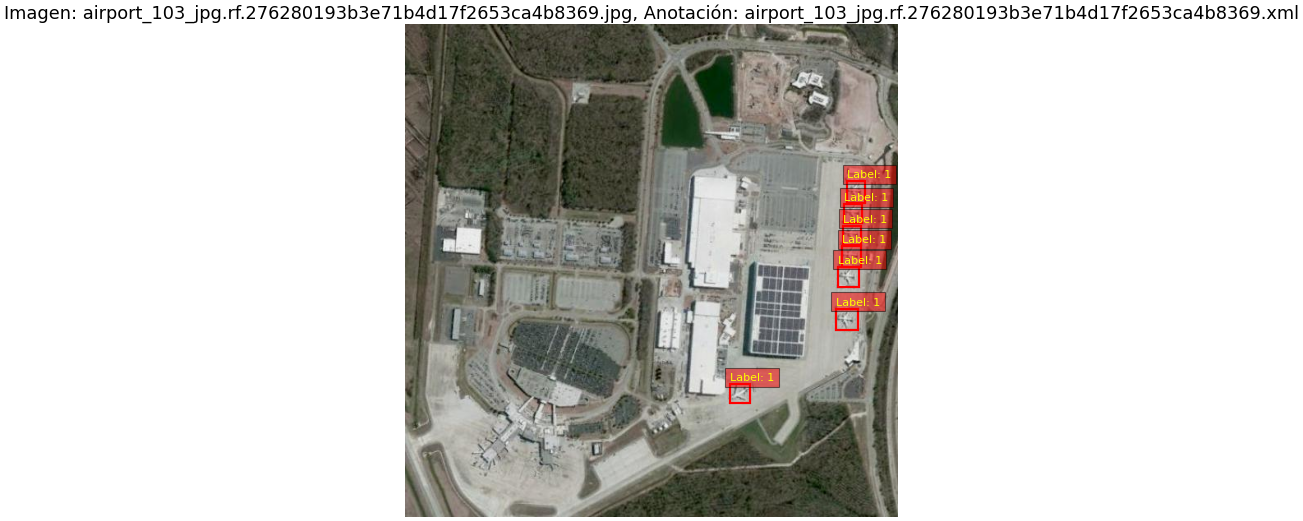

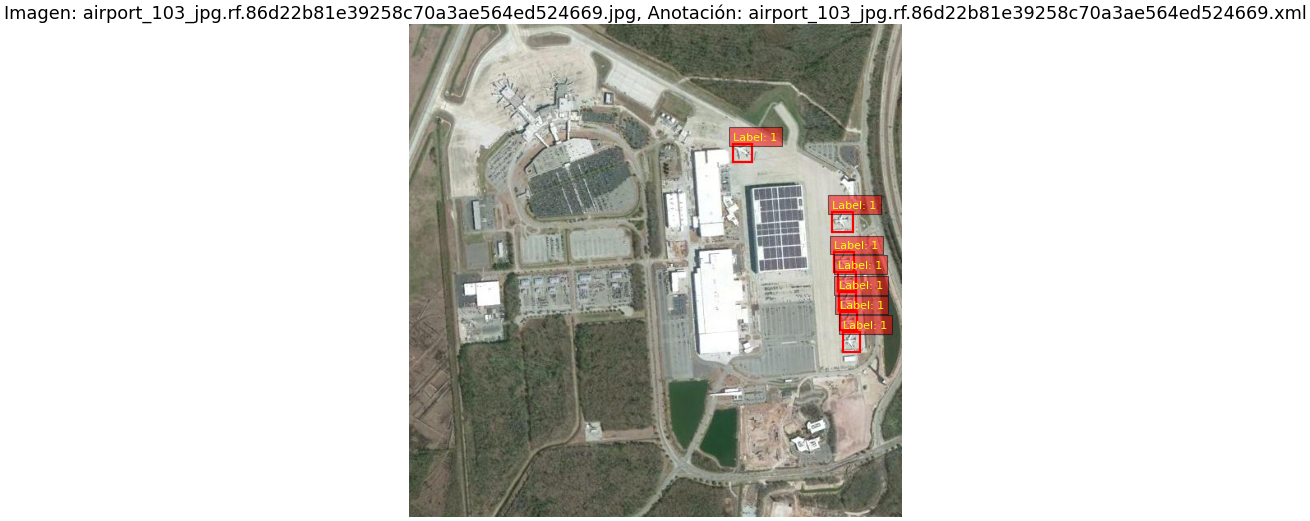

In [ ]:
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Transformaciones de datos
data_transforms = transforms.Compose([
    transforms.Resize((600, 600)),
    transforms.ToTensor(),
])

# Crear instancia del dataset
dataset = CustomDiffusionDataset(PATH_XMLS_ORGINAL + 'train/', transforms=data_transforms)



# Visualizar ejemplos
visualize_dataset(dataset, num_examples=5)


In [ ]:
def collate_fn(batch):
    """
    Combina un batch en una estructura compatible con el modelo.

    Args:
        batch: Lista de tuplas (img, target, img_filename, xml_filename).

    Returns:
        tuple: ([img1, img2, ...], [target1, target2, ...], [filename1, filename2, ...], [xmlname1, xmlname2, ...])
    """
    images, targets, img_filenames, xml_filenames = zip(*batch)
    return list(images), list(targets), list(img_filenames), list(xml_filenames)

In [ ]:
# normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
data_transforms = transforms.Compose([
    transforms.Resize((600, 600)),
    transforms.ToTensor(),
])

# Directorios de datos
train_data = PATH_XMLS_ORIGINAL + 'train/'
valid_data = PATH_XMLS_ORIGINAL + 'valid/'
test_data = PATH_XMLS_ORIGINAL + 'test/'


# Crear datasets
train_dataset = CustomDiffusionDataset(train_data, data_transforms)
val_dataset = CustomDiffusionDataset(valid_data, data_transforms)
test_dataset = CustomDiffusionDataset(test_data, data_transforms)

# Crear dataloaders
batch_size = 8  # Tamaño del batch
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# Verificar los datos del DataLoader
for batch_idx, (images, targets, filenames, xmlnames) in enumerate(train_loader):
    print(f"Lote {batch_idx + 1}:")
    print(f"  Imágenes: {len(images)}")
    print(f"  Targets: {len(targets)}")
    print(f"  Archivos de imagen: {filenames}")
    print(f"  Archivos XML: {xmlnames}")
    if batch_idx == 2:  # Limitar a los primeros 3 lotes para la verificación
        break


Lote 1:
  Imágenes: 8
  Targets: 8
  Archivos de imagen: ['airport_69_jpg.rf.558e5d0ce267a9686cf68849fc5e1332.jpg', 'airport_212_jpg.rf.522805d281456fd4ceccfe1204d8a6fb.jpg', 'airport_292_jpg.rf.12ac3ea1888a88c077239fb419350256.jpg', 'airport_78_jpg.rf.11525a7b619b6448390b03de27bd5246.jpg', 'airport_44_jpg.rf.de90bece9498e57cde807cbd6b6945ac.jpg', 'airport_33_jpg.rf.2aba34f7b639aba6399854ce5e0a16b3.jpg', 'airport_37_jpg.rf.24f80dcfb3a334c42e95b058cb8c0785.jpg', 'airport_293_jpg.rf.af778fae7425b04daec741256086d320.jpg']
  Archivos XML: ['airport_69_jpg.rf.558e5d0ce267a9686cf68849fc5e1332.xml', 'airport_212_jpg.rf.522805d281456fd4ceccfe1204d8a6fb.xml', 'airport_292_jpg.rf.12ac3ea1888a88c077239fb419350256.xml', 'airport_78_jpg.rf.11525a7b619b6448390b03de27bd5246.xml', 'airport_44_jpg.rf.de90bece9498e57cde807cbd6b6945ac.xml', 'airport_33_jpg.rf.2aba34f7b639aba6399854ce5e0a16b3.xml', 'airport_37_jpg.rf.24f80dcfb3a334c42e95b058cb8c0785.xml', 'airport_293_jpg.rf.af778fae7425b04daec741256086d3

In [ ]:
# Función para modificar la imagen usando Stable Diffusion
def augment_image_with_stable_diffusion(original_image, annotations, pipe, prompt):
    """
    Modifica el contenido de las bounding boxes usando Stable Diffusion.
    """
    largest_bbox = max(annotations, key=lambda bbox: (bbox[2] - bbox[0]) * (bbox[3] - bbox[1]))
    xmin, ymin, xmax, ymax = largest_bbox

    # Recortar y redimensionar la imagen más grande
    cropped_image = original_image.crop((xmin, ymin, xmax, ymax))
    cropped_image = cropped_image.resize((512, 512), Image.Resampling.LANCZOS)

    # Generar imagen con Stable Diffusion
    generated_image = pipe(
        prompt=prompt,
        image=cropped_image,
        strength=0.75,
        guidance_scale=25,
        num_inference_steps=400
    ).images[0]

    # Superponer el contenido generado en todas las bounding boxes
    result_image = original_image.copy()
    for bbox in annotations:
        xmin, ymin, xmax, ymax = map(int, bbox)
        patch_resized = generated_image.resize((xmax - xmin, ymax - ymin), Image.Resampling.LANCZOS)
        result_image.paste(patch_resized, (xmin, ymin))

    return result_image


In [ ]:
def augment_dataset(dataset, output_dir, pipe, prompt="An overhead shot of a single airplane on a plain grey surface, photorealistic and detailed."):
    """
    Aplica data augmentation al dataset completo usando Stable Diffusion.
    Genera nuevas imágenes duplicando el número total de ejemplos y guarda las imágenes aumentadas.
    Si una imagen no tiene anotaciones, la omite del proceso.
    """
    os.makedirs(output_dir, exist_ok=True)

    for idx in range(len(dataset)):
        img, target, img_filename, xml_filename = dataset[idx]

        # Extraer bounding boxes y etiquetas
        annotations = target["boxes"].tolist()

        # Si no hay bounding boxes, omitir esta imagen
        if not annotations:
            print(f"Advertencia: No se encontraron bounding boxes para la imagen {img_filename}. Saltando...")
            continue

        # Convertir imagen a formato PIL
        if isinstance(img, torch.Tensor):
            img = transforms.ToPILImage()(img)

        # Modificar la imagen
        augmented_image = augment_image_with_stable_diffusion(img, annotations, pipe, prompt)

        # Guardar la nueva imagen aumentada
        base_name = os.path.splitext(img_filename)[0]
        augmented_img_path = os.path.join(output_dir, f"{base_name}_aug.jpg")
        augmented_image.save(augmented_img_path)

        # Guardar el archivo XML duplicado con el nombre correspondiente
        original_xml_path = os.path.join(dataset.root_dir, xml_filename)
        augmented_xml_path = os.path.join(output_dir, f"{base_name}_aug.xml")
        shutil.copyfile(original_xml_path, augmented_xml_path)


In [ ]:
# Configuración del pipeline de Stable Diffusion
torch.cuda.empty_cache()
pipe = StableDiffusionXLImg2ImgPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16,
)
pipe.to("cuda")

# Directorio de salida
output_dir = PATH_PROYECTO + 'augmented/'

# Aplicar data augmentation
augment_dataset(train_dataset, output_dir, pipe)


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Advertencia: No se encontraron bounding boxes para la imagen airport_168_jpg.rf.29aa26edcfade11c9310bc71672bb435.jpg. Saltando...
Advertencia: No se encontraron bounding boxes para la imagen airport_168_jpg.rf.62886a19b6e8b100a2b96e8c7b592a6e.jpg. Saltando...
Advertencia: No se encontraron bounding boxes para la imagen airport_168_jpg.rf.7b2cf5d9c2b4aa8033cd40c42366f6eb.jpg. Saltando...


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Advertencia: No se encontraron bounding boxes para la imagen airport_177_jpg.rf.5b5ae1b15ed06a9db568ceef51a45392.jpg. Saltando...
Advertencia: No se encontraron bounding boxes para la imagen airport_177_jpg.rf.b81d4e0b59a6f9adcc1bb7a6fc4d339d.jpg. Saltando...
Advertencia: No se encontraron bounding boxes para la imagen airport_177_jpg.rf.e7a1df01d7f66ffc82ffb0afbf07c404.jpg. Saltando...


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Advertencia: No se encontraron bounding boxes para la imagen airport_76_jpg.rf.419becaa0edc8d9429e9babd6316f8f5.jpg. Saltando...
Advertencia: No se encontraron bounding boxes para la imagen airport_76_jpg.rf.73b87ee641eb9762b3b091c88116a71f.jpg. Saltando...
Advertencia: No se encontraron bounding boxes para la imagen airport_76_jpg.rf.834c0cc4fd113a5d3ac0c816315de18a.jpg. Saltando...


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]